# Atividade de Redes Convolucionais

## Felipe Gibin

## 1. Introdução

### 1.1 Bibliotecas

In [36]:
#Bibliotecas usadas
from tensorflow.keras.preprocessing import image_dataset_from_directory
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight

## 2. Pré-processamento e Organização dos Dados

### 2.1 Estrutura do Dataset

O dataset segue a seguinte estrutura:

```text
clouds/
├── cloud_train/
│   ├── cirriform clouds/
│   ├── cumulonimbus clouds/
│   ├── stratiform clouds/
│   ├── clear sky/
│   └── ... (outros tipos de nuvem)
└── cloud_test/
    ├── cirriform clouds/
    ├── cumulonimbus clouds/
    ├── stratiform clouds/
    ├── clear sky/
    └── ... (outros tipos de nuvem)
```


### 2.2 Carregar e Dividir os Dados

In [16]:
drive.mount('/content/drive') # Google drive

#Caminhos para os diretórios de treino e teste
train_dir = '/content/drive/MyDrive/clouds/clouds_train'
test_dir = '/content/drive/MyDrive/clouds/clouds_test'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
# Carregar datasets
test_ds = image_dataset_from_directory(
    test_dir,
    image_size=(128,128),
    batch_size=32,
    label_mode="categorical"
)

full_train_ds = image_dataset_from_directory(
    train_dir,
    image_size=(128,128),     #Redimensiona para 128,128 pixels conforme o exemplo
    batch_size=32,
    label_mode="categorical", #Para podermos usar one-hot
    shuffle=True,
    seed=123                  #Aleatoriedade
)

#Separa 20% para validação
train_size = int(0.8 * len(full_train_ds))
val_size = len(full_train_ds) - train_size

train_ds = full_train_ds.take(train_size)
val_ds = full_train_ds.skip(train_size)

Found 486 files belonging to 7 classes.
Found 474 files belonging to 7 classes.


### 2.3 Visualização de algumas imagens

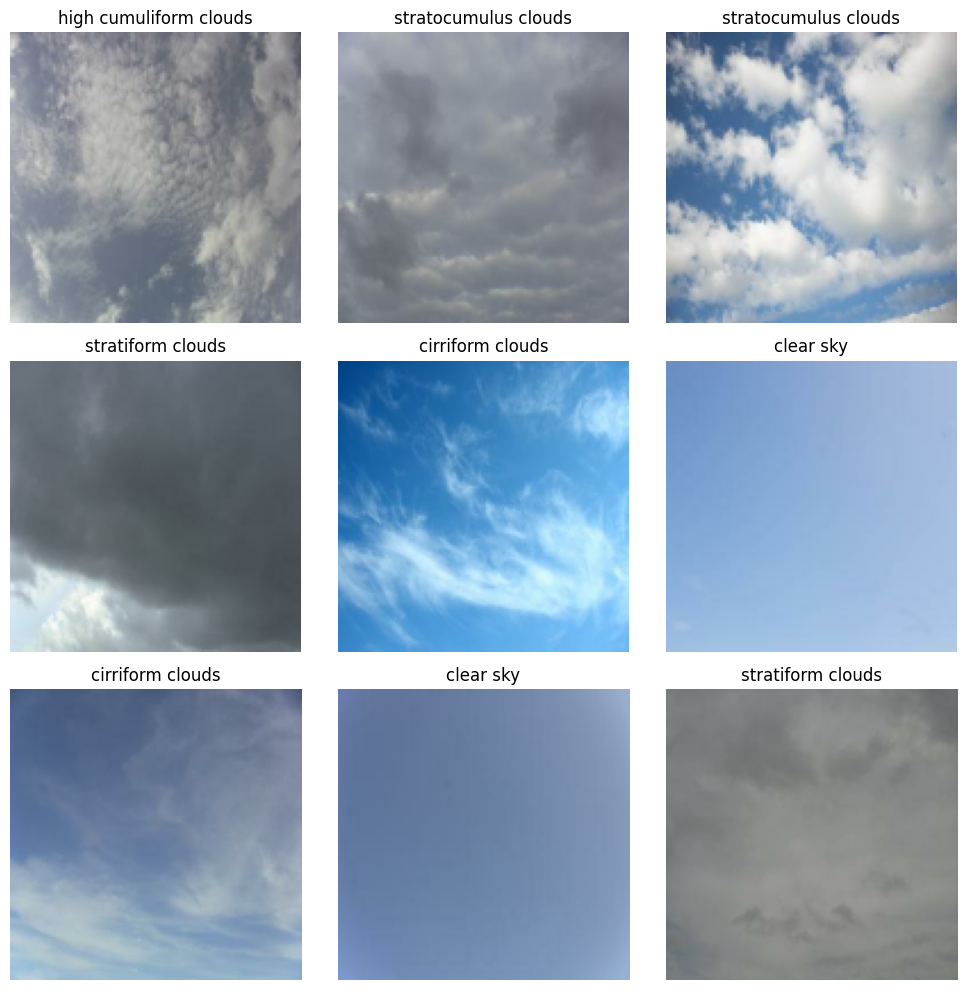

In [22]:
# Pega nome das classes do dataset de teste
class_names = test_ds.class_names

# pega apenas o primeiro batch
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):  # mostrar 9 imagens aleatórias
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy().argmax()])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

## 3. CNN sem regularização



### 3.1 Definindo o modelo

In [23]:
model_cnn_no_reg = Sequential([
    layers.Input(shape=(128,128, 3)),
    layers.Rescaling(1./255),  # Normalização

    # Blocos Convolucionais
    layers.Conv2D(32, (3, 3), activation="relu", padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(64, (3, 3), activation="relu", padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(128, (3, 3), activation="relu", padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),  # Processa o resultado do flatten
    layers.Dense(7, activation="softmax")  # 7 classes
])

### 3.2 Treinamento

In [37]:
train_labels = np.concatenate([y for x, y in train_ds], axis=0)
class_weights = compute_class_weight('balanced', classes=np.unique(np.argmax(train_labels, axis=1)), y=np.argmax(train_labels, axis=1))
class_weights = dict(enumerate(class_weights))

In [38]:
model_cnn_no_reg.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_cnn_no_reg = model_cnn_no_reg.fit(
    train_ds,
    class_weight=class_weights,
    validation_data=val_ds,
    epochs=20,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)]
)

Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 246ms/step - accuracy: 0.6732 - loss: 1.5364 - val_accuracy: 0.5222 - val_loss: 1.3268
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 174ms/step - accuracy: 0.6311 - loss: 0.7343 - val_accuracy: 0.7222 - val_loss: 0.6679
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 172ms/step - accuracy: 0.7291 - loss: 0.6170 - val_accuracy: 0.8667 - val_loss: 0.5444
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step - accuracy: 0.8450 - loss: 0.4781 - val_accuracy: 0.8667 - val_loss: 0.4234
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step - accuracy: 0.8893 - loss: 0.2793 - val_accuracy: 0.8556 - val_loss: 0.3977
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 214ms/step - accuracy: 0.8927 - loss: 0.2178 - val_accuracy: 0.8000 - val_loss: 0.4878
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 205ms/step - accuracy: 0.8619 - loss: 0.2591 - val_accuracy: 0.9222 - val_loss: 0.2538
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step - accuracy: 0.9142 - loss: 0.2078 - val_accuracy: 0.

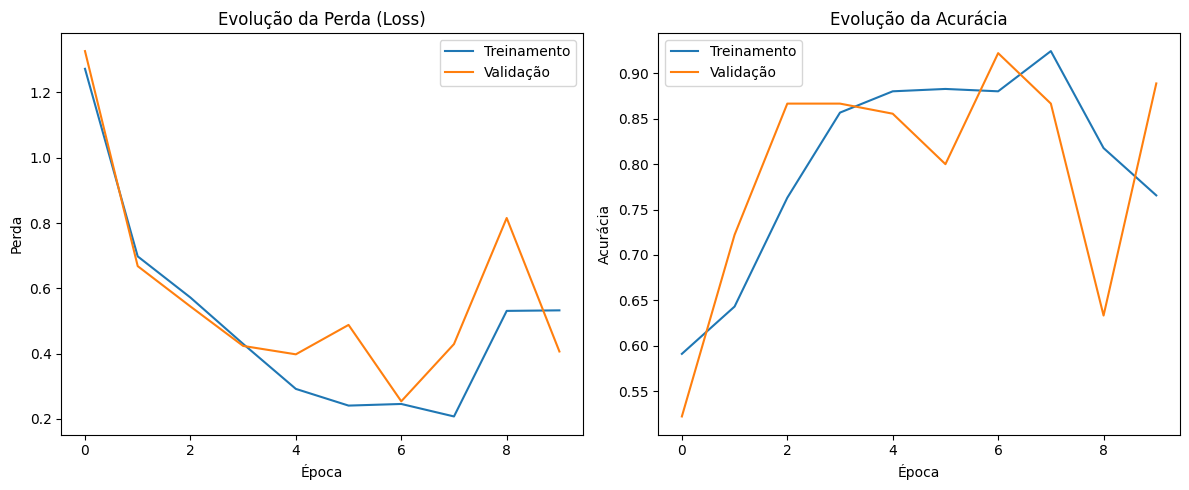

In [39]:
#Evolução das curvas de perda e acurácia

plt.figure(figsize=(12, 5))

# Curva de perda
plt.subplot(1, 2, 1)
plt.plot(history_cnn_no_reg.history['loss'], label='Treinamento')
plt.plot(history_cnn_no_reg.history['val_loss'], label='Validação')
plt.title('Evolução da Perda (Loss)')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()

# Curva de acurácia
plt.subplot(1, 2, 2)
plt.plot(history_cnn_no_reg.history['accuracy'], label='Treinamento')
plt.plot(history_cnn_no_reg.history['val_accuracy'], label='Validação')
plt.title('Evolução da Acurácia')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

plt.tight_layout()
plt.show()


Avaliar de novo.








Vemos que há indícios de overfitting, o que não surpreende dada a ausência de data augmentation nesse modelo. Podemos destacar que a acurácia de treinamento aumenta consistentemente, mas a de avaliação não acompanha o mesmo ritmo e oscila. De forma similar, a perda de validação começa a oscilar e até aumenta, mesmo com a perda de treino caindo.


### 3.3 Avaliação breve

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


<Figure size 1000x800 with 0 Axes>

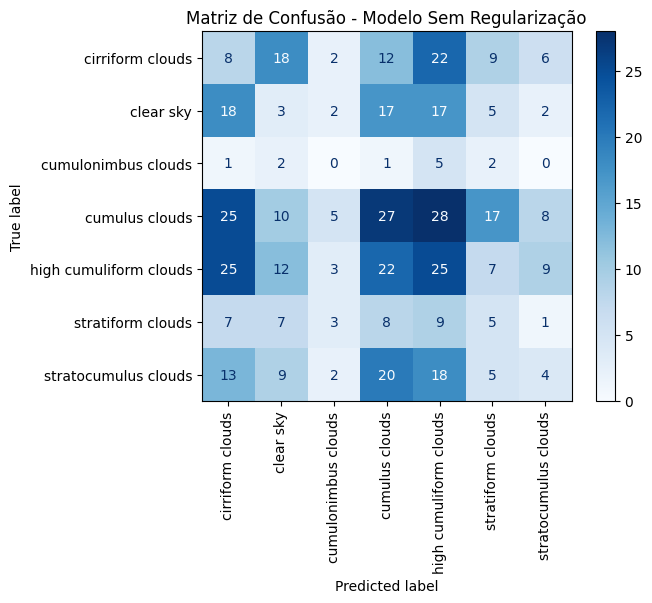

In [40]:
# Previsões (outputs da softmax)
y_pred_probs = model_cnn_no_reg.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)  # Índices das classes preditas

#Rótulos verdadeiros
y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for x, y in test_ds])

cm = confusion_matrix(y_true, y_pred)
class_names = test_ds.class_names

# Visualizacao
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=90)
plt.title("Matriz de Confusão - Modelo Sem Regularização")
plt.show()


In [41]:
# Report básico
report = classification_report(y_true, y_pred, target_names=test_ds.class_names)
print(report)

                        precision    recall  f1-score   support

      cirriform clouds       0.08      0.10      0.09        77
             clear sky       0.05      0.05      0.05        64
   cumulonimbus clouds       0.00      0.00      0.00        11
        cumulus clouds       0.25      0.23      0.24       120
high cumuliform clouds       0.20      0.24      0.22       103
     stratiform clouds       0.10      0.12      0.11        40
  stratocumulus clouds       0.13      0.06      0.08        71

              accuracy                           0.15       486
             macro avg       0.12      0.11      0.11       486
          weighted avg       0.15      0.15      0.15       486

